In [ ]:
# Additional requirements just for this notebook:

# !pip install huggingface_hub[cli]
# !pip install esm 
# !pip install py3Dmol

In [1]:
# General:
import os 
import io
from omegaconf import OmegaConf
# import huggingface_hub
import requests
import pathlib
import pickle
import pandas as pd
import numpy as np
import torch

# ESM:
# from esm.models.esmc import ESMC
# from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, LogitsConfig, GenerationConfig
from esm.utils.structure.protein_chain import ProteinChain
# from esm.utils.types import FunctionAnnotation
from biotite.database import rcsb
# from fa_helper import visualize_function_annotations, get_keywords_from_interpro, interpro2keywords
from scripts.helpers.pdb import gene_to_pdb, fetch_pdb_ids

# Visualization:
import matplotlib.pyplot as plt
from scripts.helpers.visualization import visualize_3D_protein
from PIL import Image
from IPython.display import SVG
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from synformer.models.synformer import draw_generation_results

# Chemistry:
from rdkit import Chem
import rdkit

# Synformer:
# from synformer.chem.fpindex import FingerprintIndex
# from synformer.chem.matrix import ReactantReactionMatrix
# from synformer.chem.mol import Molecule
from synformer.models.synformer import Synformer
from scripts.sample_helpers import load_model, featurize_smiles, load_protein_molecule_pairs, sample

In [2]:
# Loading ESM-related configs:
assert os.path.exists("configs/esm.yml"), "Missing config file: configs/esm.yml" 
esm_config = OmegaConf.load("configs/esm.yml")
# huggingface_hub.login(esm_config.hf_token)

### 1. Loading the data

In [3]:
# Dataset paths
# protein_molecule_pairs_path = "data/protein_molecule_pairs/papyrus_val_19399.csv"
protein_molecule_pairs_path = "data/protein_molecule_pairs/papyrus_test_19399.csv"
protein_embeddings_path = "data/protein_embeddings/embeddings_selection_float16_4973.pth"
synthetic_pathways_path = "data/synthetic_pathways/filtered_pathways_370000.pth"

In [4]:
df_protein_molecule_pairs = load_protein_molecule_pairs(protein_molecule_pairs_path)
df_protein_molecule_pairs = df_protein_molecule_pairs.reset_index()

# Some example entries
df_protein_molecule_pairs.sample(10)

,SMILES,target_id,short_target_id
12461,O=C(NCC(c1ccccc1)N1CCN(C2CCCCC2)CC1)Nc1cc(Cl)c...,P51677_WT,P51677
17924,O=C(Nc1ccc(OC(F)(F)F)cc1)N1CCC2(CCN(C(=O)c3ccc...,P34913_WT,P34913
6202,Cc1cccc(Cl)c1S(=O)(=O)N1CCC(C)(N2CCC(O)(c3ccc(...,P32246_WT,P32246
4510,CC(CCO)CNCc1ccc(F)c(-c2ccc(OCC(F)(F)F)nc2)n1,Q8NET8_WT,Q8NET8
13113,O=C(O)c1c(NN=Cc2ccc(-c3ccccc3Cl)o2)cccc1,Q02127_WT,Q02127
14644,O=C(Nc1cc(Cl)c(Cl)cc1)c1ccc(Cl)c(Cl)c1,Q03431_WT,Q03431
15146,CC(=O)c1ccc(NC(=O)c2nsnc2)cc1,Q03431_WT,Q03431
6231,Cc1ccc(C(=O)N2CC3CN(c4nc(C)cc(C)n4)CC3C2)c(C)c1,O43613_WT,O43613
17835,CCCCCOc1ccccc1-c1cc(C(=O)NC2CCCCCCC2)no1,P34972_WT,P34972
16165,COc1ccccc1NC(=O)Nc1nc(CC(=O)N2CCN(c3ccccc3F)CC...,Q03431_WT,Q03431


In [5]:
protein_embeddings = torch.load(protein_embeddings_path, map_location=torch.device("cpu"))
print(len(protein_embeddings), "protein embeddings")

synthetic_pathways = torch.load(synthetic_pathways_path, map_location=torch.device("cpu"))
print(len(synthetic_pathways), "synthetic pathways")

4973 protein embeddings
70936 synthetic pathways


### 2. Loading the model

In [6]:
# Protein-Synformer model configs
# config_path = "configs/prot2drug.yml"  
# config = OmegaConf.load(config_path)

# Sampling settings
model_path = "data/trained_weights/epoch=23-step=28076.ckpt"
config_path = None
device = "cpu"

In [7]:
model, fpindex, rxn_matrix = load_model(model_path, config_path, device)

### 3. Example

In [8]:
# Random example
ex_smiles, ex_target_id, ex_short_target_id = df_protein_molecule_pairs.sample().iloc[0]
ex_protein_embeddings = protein_embeddings[ex_target_id].float()
ex_synthetic_pathway_true = synthetic_pathways[ex_smiles]

print("SMILES:", ex_smiles)
print("Target:", ex_target_id)
print("Protein embeddings:", ex_protein_embeddings.shape)
print("True synthetic pathway:", ex_synthetic_pathway_true)

SMILES: Cc1ccccc1Cn1ccc(NC(=O)CCSc2nc(C(F)(F)F)cc(-c3ccco3)n2)n1
Target: Q03431_WT
Protein embeddings: torch.Size([595, 1152])
True synthetic pathway: [(1, -1), (3, 154792), (3, 124131), (2, 57), (3, 178138), (2, 21), (0, -1)]


In [9]:
ex_pdb_id, ex_df_pdb_ids = fetch_pdb_ids(ex_short_target_id)
print("PDB ID:", ex_pdb_id)

ex_protein_chain = ProteinChain.from_pdb(rcsb.fetch(ex_pdb_id, "pdb"), chain_id="A") 

# Get protein object with all the ground-truth data (except function for some reason) 
# In the code, they don't provide a way to automatically fetch function annotations, 
# instead I have to fetch them myself and then set ex_protein.function_annotations 
ex_known_protein = ESMProtein.from_protein_chain(ex_protein_chain) 

# Get protein with just the sequence data 
# So that we can predict the other tracks later 
# ex_protein = ESMProtein(sequence=ex_protein_chain.sequence) 

# print(len(ex_known_protein.sequence))
print(ex_known_protein.sequence)

# TODO: have ESM predict binding site and then also visualize it 
# (already done in Binding Site notebook)






visualize_3D_protein(ex_known_protein, style="cartoon")

PDB ID: 1BL1
SEAVKFLTNETREREVFDRLGMIYTVGYSVC


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
info, result = sample( 
    ex_target_id,
    model, 
    fpindex, 
    rxn_matrix,  
    protein_embeddings, 
    device,
    true_smiles=ex_smiles,
    repeat=50
)
# prints: analog.sim(mol), cnt_rxn, log_likelihood, analog.smiles

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
# Best one:
best_idx = pd.DataFrame(info).T["similarity"].idxmax()

print("True:", ex_smiles)
print("Pred:", info[best_idx]["smiles"])

info[best_idx]

In [ ]:
# TODO
# draw_generation_results(result)[best_idx]  







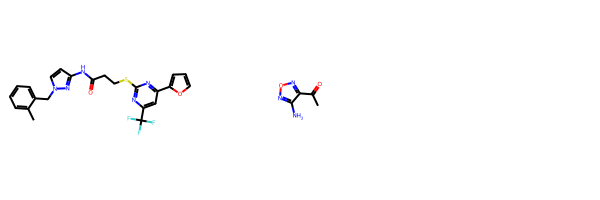

In [18]:
Draw.MolsToGridImage((
    Chem.MolFromSmiles(ex_smiles),     # true 
    Chem.MolFromSmiles(info[best_idx]["smiles"])  # predicted
))

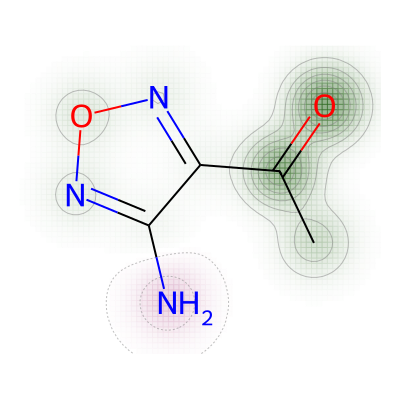

In [19]:
# Similarity map
# Source: https://greglandrum.github.io/rdkit-blog/posts/2020-01-03-similarity-maps-with-new-drawing-code.html

d = Draw.MolDraw2DCairo(400, 400)
_, max_weight = SimilarityMaps.GetSimilarityMapForFingerprint(
    Chem.MolFromSmiles(ex_smiles),
    Chem.MolFromSmiles(info[best_idx]["smiles"]), 
    lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType="bv"), 
    draw2d=d
)
d.FinishDrawing()
Image.open(io.BytesIO(d.GetDrawingText()))